# **ML LAB Part 1**

The UCI Wholesale customers dataset is an unsupervised dataset that contains the annual spending on different product categories of 440 wholesale
customers located in Portugal. The goal of this project is to generate insights into the customers' spending behaviours, cluster the customer into groups and detect and isolate customers with anomalous spending behaviours to explain why their spending behaviours appear to be anomalous.

# 1: Loading the Data, Preprocessing, Initial Data Analysis

The unprocessed dataset: 
    Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185 

The dataset after performing log transformation: 
        Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0   9.446992  9.175438  8.930891  5.370638          7.891705    7.199678
1   8.861917  9.191259  9.166284  7.474772          8.099858    7.482682
2   8.756840  9.083529  8.947026  7.785721          8.165364    8.967632
3   9.492960  7.087574  8.348064  8.764834          6.230481    7.489412
4  10.026413  8.596189  8.881697  8.272826          7.483244    8.553718


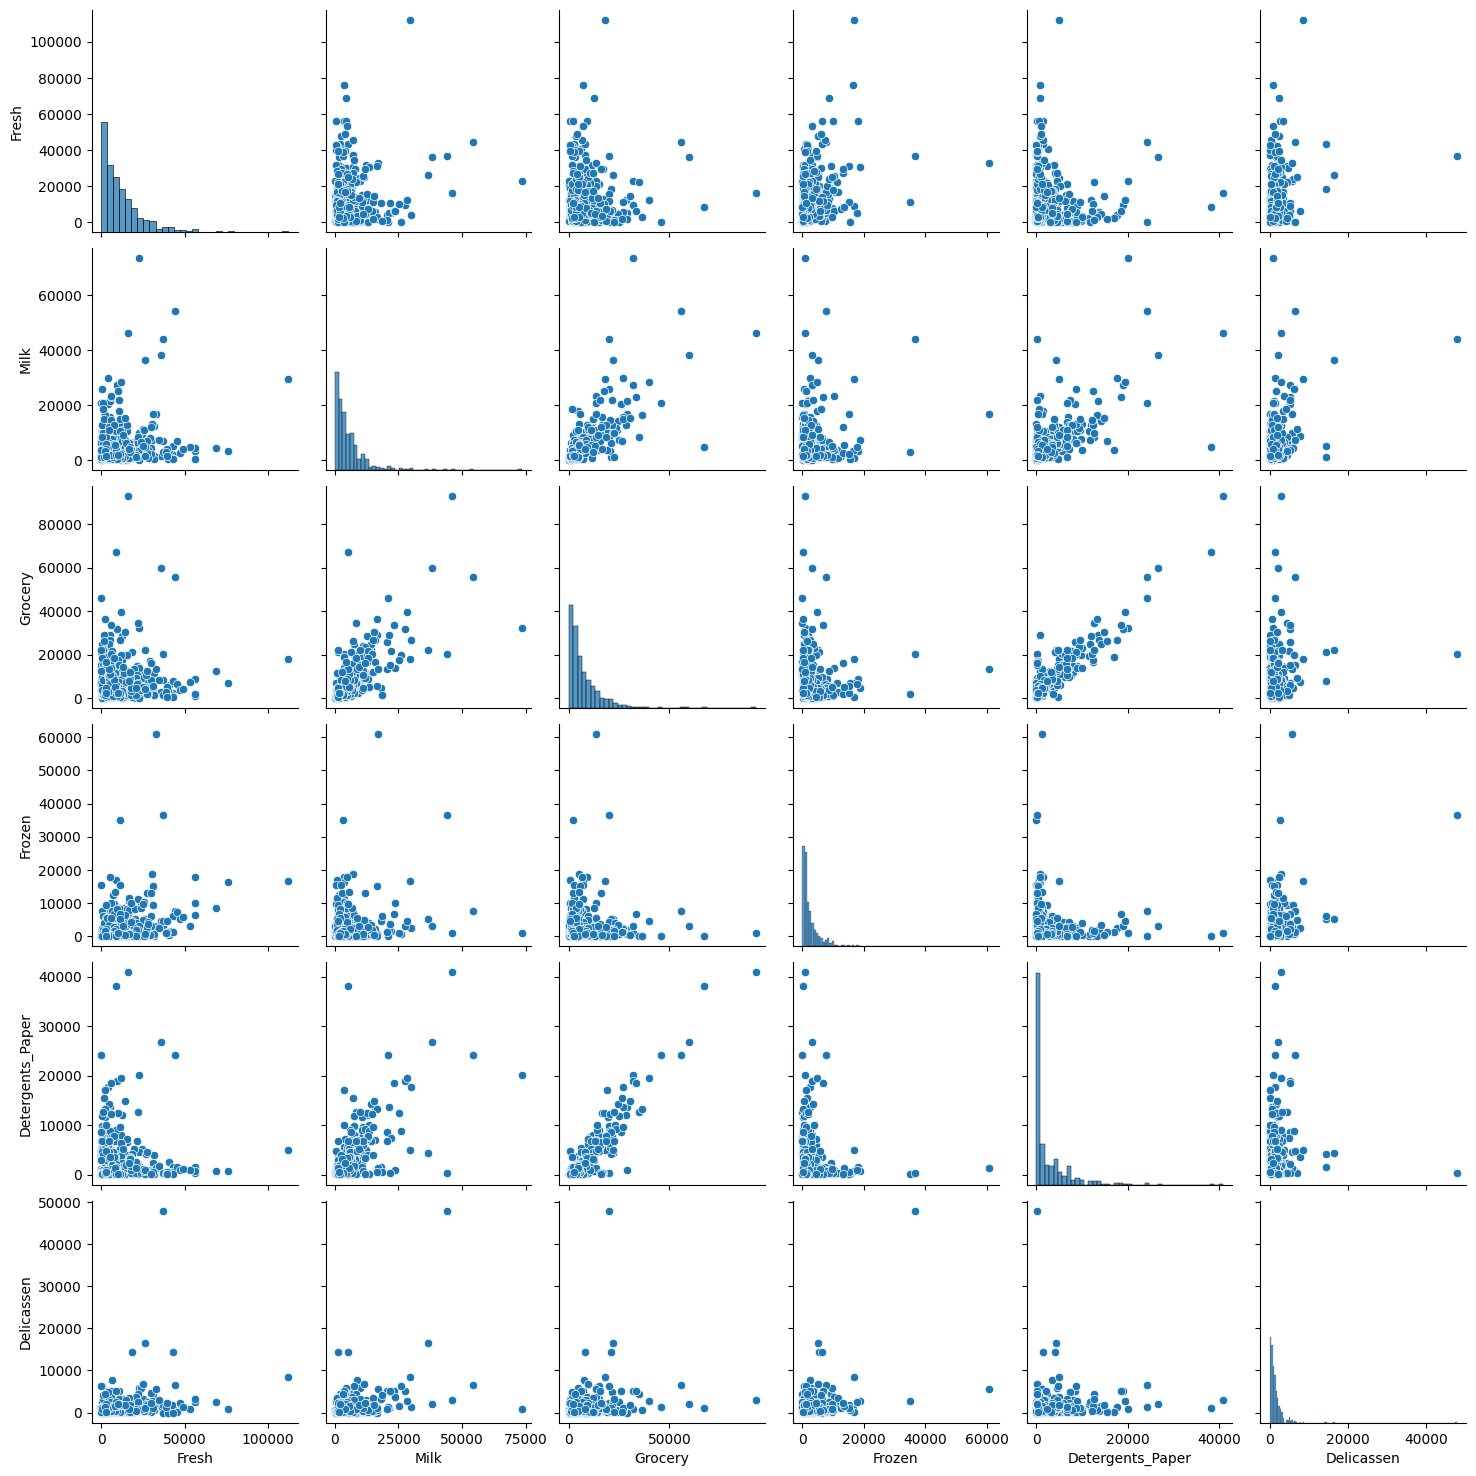

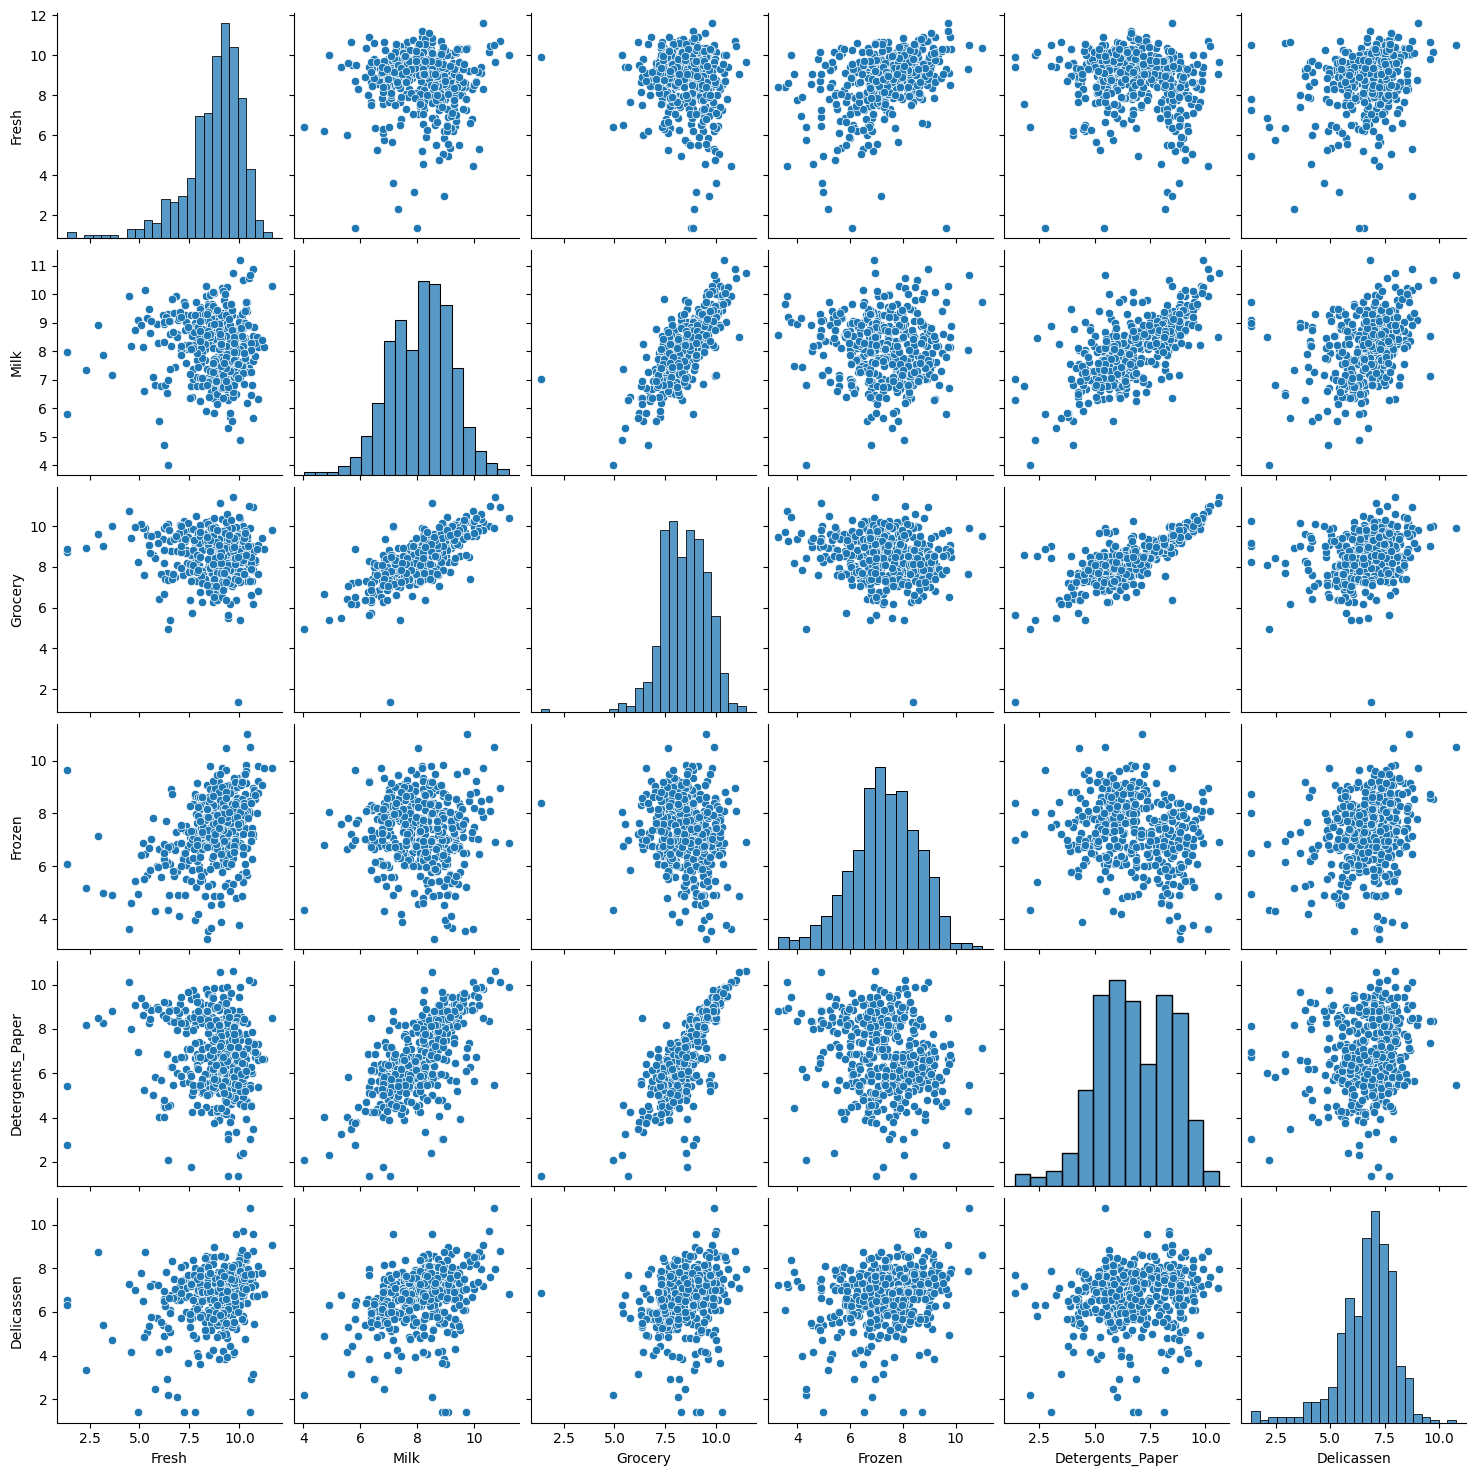

                     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh             1.000000 -0.021096 -0.132989  0.386258         -0.158706   
Milk             -0.021096  1.000000  0.761128 -0.055229          0.678725   
Grocery          -0.132989  0.761128  1.000000 -0.164525          0.797141   
Frozen            0.386258 -0.055229 -0.164525  1.000000         -0.212771   
Detergents_Paper -0.158706  0.678725  0.797141 -0.212771          1.000000   
Delicassen        0.256442  0.342310  0.239998  0.256318          0.167573   

                  Delicassen  
Fresh               0.256442  
Milk                0.342310  
Grocery             0.239998  
Frozen              0.256318  
Detergents_Paper    0.167573  
Delicassen          1.000000  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# import cupy as cp
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)
print("The unprocessed dataset: \n", df.head(), "\n")

# Drop columns Channel + Region
df = df.drop(columns=['Channel', 'Region'])

# Apply log transformation
df_log = np.log1p(df)

# Plot histograms and scatter plots
print("The dataset after performing log transformation: \n", df_log.head())
sns.pairplot(df)
plt.show()
sns.pairplot(df_log)
plt.show()

correlation_matrix = df_log.corr(method='pearson')
print(correlation_matrix)

# 2: Detecting Anomalies

We use bootstrapping to generate multiple subsets of the dataset and calculate anomaly scores for each subset using a softmin function controlled by a gamma parameter. Our idea is to iterate over a range of gamma values, seeking to maximize the mean variance and minimize the overall variance of anomaly scores. The optimal gamma is chosen as the one that minimizes the variance of variances across all bootstraped samples but still keeps the variance of anomaly scores inside each bootstrapped sample high. Using this optimal gamma, the final anomaly scores are calculated and the top 10 anomalies, those with the highest scores, are identified.

In [ ]:
import scipy.special

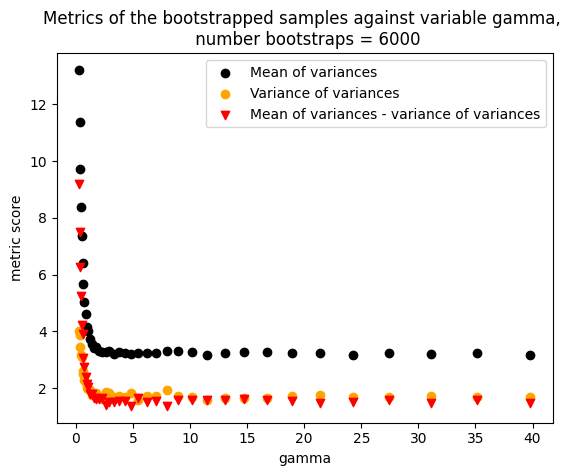

In [ ]:

def make_zjk_vect(x):
  difference = np.expand_dims(x, axis=1) - np.expand_dims(x, axis=0)
  output = np.square(np.linalg.norm(difference, axis=2))
  indices = np.diag_indices(output.shape[0])
  mask = np.ones(output.shape, dtype=bool)
  mask[indices] = False
  result = output[mask].reshape(output.shape[0], -1)
  return result

def softmin_new_vect(z, gamma):
  N = z.shape[0]
  softmin_values = scipy.special.logsumexp(-gamma*z, axis=1, b=1/(N-1))* (-1 / gamma)
  return softmin_values

#transform dataframe into numpy array (matrix)
datamatrix = df_log.to_numpy()
datamatrix = np.asarray(datamatrix)

def bootstrap_anomaly_scores(data, gamma, n_bootstraps):
  var = np.zeros(n_bootstraps)
  n_samples = data.shape[0]
  # Generate bootstrap samples and compute anomaly scores
  for i in range(n_bootstraps):
      # Generate a bootstrap sample
      bootstrap_sample = resample(data, n_samples=n_samples)
      bs = np.asarray(bootstrap_sample)
      # Compute anomaly scores
      anomaly_scores = softmin_new_vect(make_zjk_vect(bs), gamma)
      # Store the anomaly score for this bootstrap sample
      var[i] = (np.var(anomaly_scores))
  return np.var(var), np.mean(var)

# Set the number of bootstrap samples
n_bootstraps = 1000
n_samples = datamatrix.shape[0]

# Set the range of gamma values to test
gamma_values = np.logspace(-0.5, 1.6, num=40)

mean_variances = np.zeros(gamma_values.size) #needs to be maximised
variance_of_variances = np.zeros(gamma_values.size) #needs to be minimised

# Loop over each gamma value
for count,gamma in enumerate(gamma_values):
    (var_var, mean_var) = bootstrap_anomaly_scores(datamatrix, gamma, n_bootstraps)
    mean_variances[count] = mean_var
    variance_of_variances[count] = var_var

# The optimal gamma is the one that minimizes the anomaly score variancy
plt.scatter(gamma_values,mean_variances, c="black", label = "Mean of variances") #needs to be maximised
plt.scatter(gamma_values,variance_of_variances, c="orange", label = "Variance of variances") #needs to be minimised
plt.scatter(gamma_values,mean_variances-variance_of_variances, c="red", marker = "v", label = "Mean of variances - variance of variances")
plt.legend()
plt.xlabel("gamma")
plt.ylabel("metric score")
plt.title("Metrics of the bootstrapped samples against variable gamma, \n number bootstraps = 1000")
plt.show()

optimal_gamma = gamma_values[np.argmin(variance_of_variances)]
anomaly_scores = softmin_new_vect(make_zjk_vect(datamatrix), optimal_gamma)
top_anomalies = np.argsort(anomaly_scores)[-10:]


optimal gamma:  11.52228097739821 

Top 10 anomalies: 
 [109 204 183 128 187  95 142 154  75 338] 



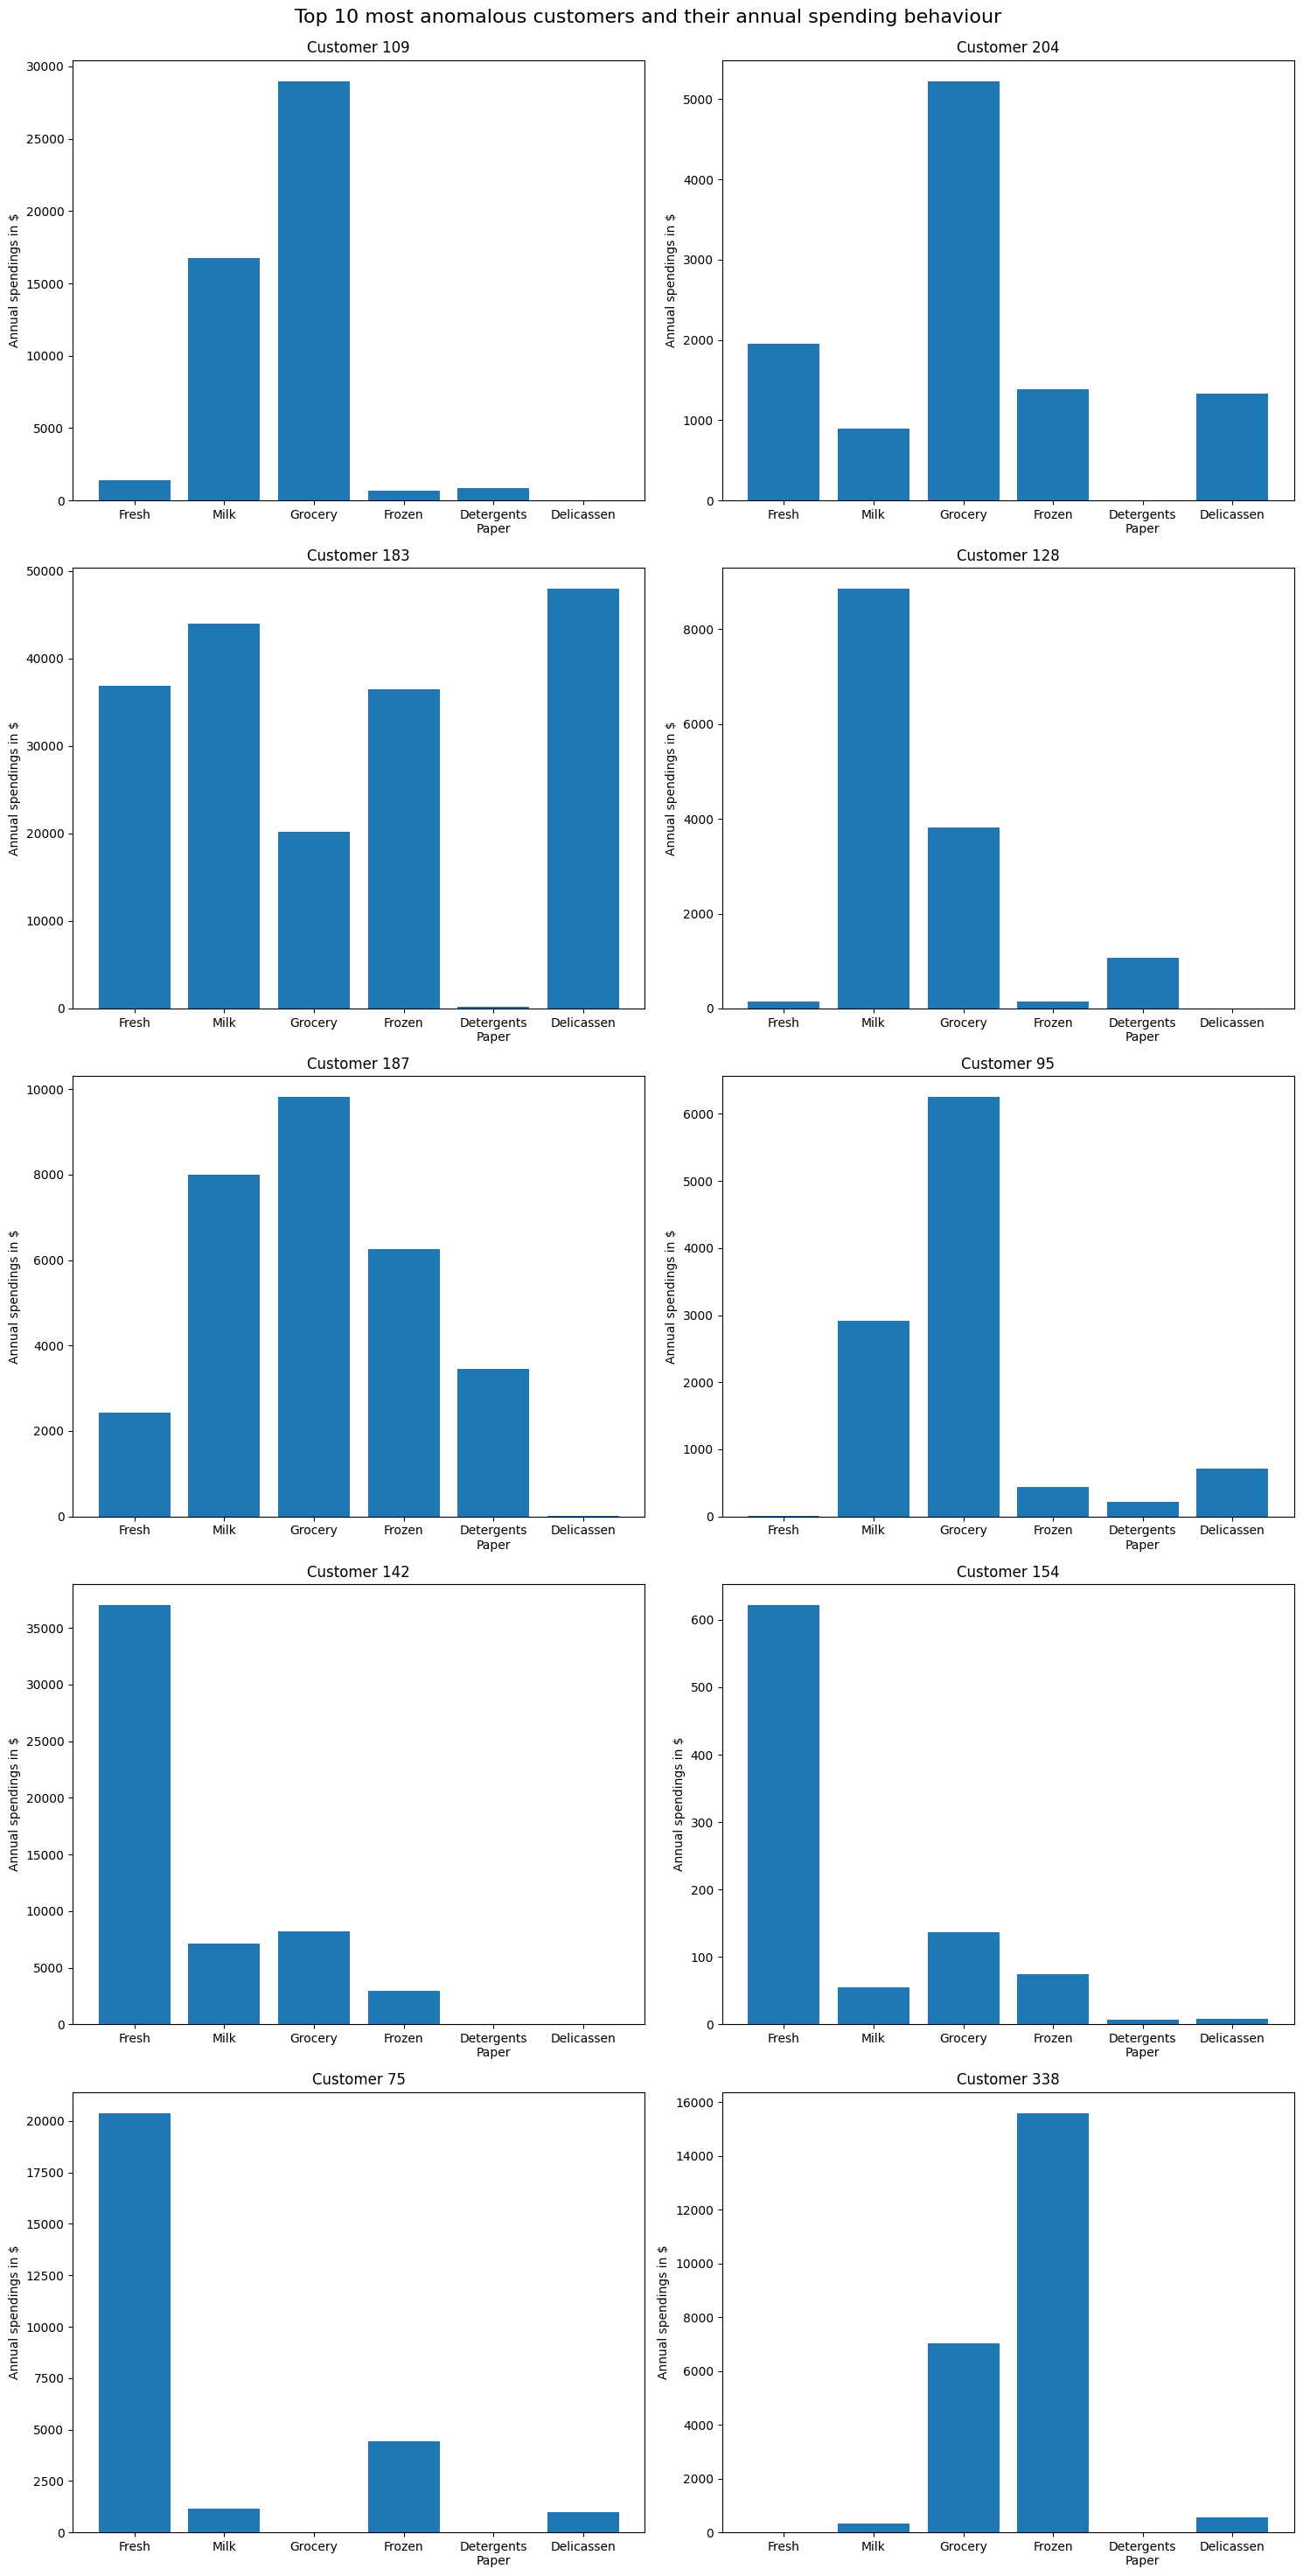

In [ ]:
print("optimal gamma: ", optimal_gamma, "\n")
print("Top 10 anomalies: \n", top_anomalies, "\n")

fig, axs = plt.subplots(5, 2, figsize=(15, 30))
for i, anom in enumerate(top_anomalies):
    row = i // 2
    col = i % 2
    axs[row, col].bar(["Fresh", "Milk", "Grocery", "Frozen", "Detergents\nPaper", "Delicassen"], df.loc[anom])
    axs[row, col].set_ylabel("Annual spendings in $")
    axs[row, col].set_title("Customer {}".format(anom))


fig.suptitle("Top 10 most anomalous customers and their annual spending behaviour \n \n", fontsize=16)
plt.tight_layout()
plt.show()

# 3: Explaining Anomalies

In order to understand how much influence each customer's spending behaviour had on his anomaly score, first one can identify how much influence the other customers had on his anomaly score. Then, these scores can be propagated back to the input features and decomposed into individual components.



In [ ]:
def compute_Rk(zjk, yj, gamma):
    n = zjk.shape[0]
    Rk = np.zeros_like(zjk)
    for j in range(n):
        for k in range(n-1):
                num = np.exp(-gamma * zjk[j,k])
                denom = np.sum(np.exp(-gamma * zjk[j,:])) # exclude zjj in the sum
                Rk[j,k] = (num / denom) * yj[j]
    return Rk


def expand_matrix(matrix):
    # Create a new square matrix filled with zeros
    n = matrix.shape[0]
    expanded_matrix = np.zeros((n, n))
    # Copy the elements from the input matrix
    for i in range(n):
        for j in range(n):
          expanded_matrix[i, 0:i] = matrix[i,0:i]
          expanded_matrix[i, i+1:] = matrix[i,i:]
    return expanded_matrix


def compute_Rji(X, Rk):
    n = X.shape[0]
    d = X.shape[1]  # number of features
    Rji = np.zeros_like(X)
    rk = expand_matrix(Rk)
    for j in range(n):
        for i in range(d):
            for k in range(n):
                if j != k:
                    xk_xj_diff = np.square(X[k, i] - X[j, i])
                    norm_xk_xj = np.square(np.linalg.norm(X[k, :] - X[j, :]))
                    Rji[j, i] += (((xk_xj_diff * rk[j, k])/ norm_xk_xj ) if norm_xk_xj != 0 else 0)
    return Rji



RK = compute_Rk(make_zjk_vect(datamatrix), anomaly_scores, optimal_gamma)
rji = compute_Rji(datamatrix,RK)

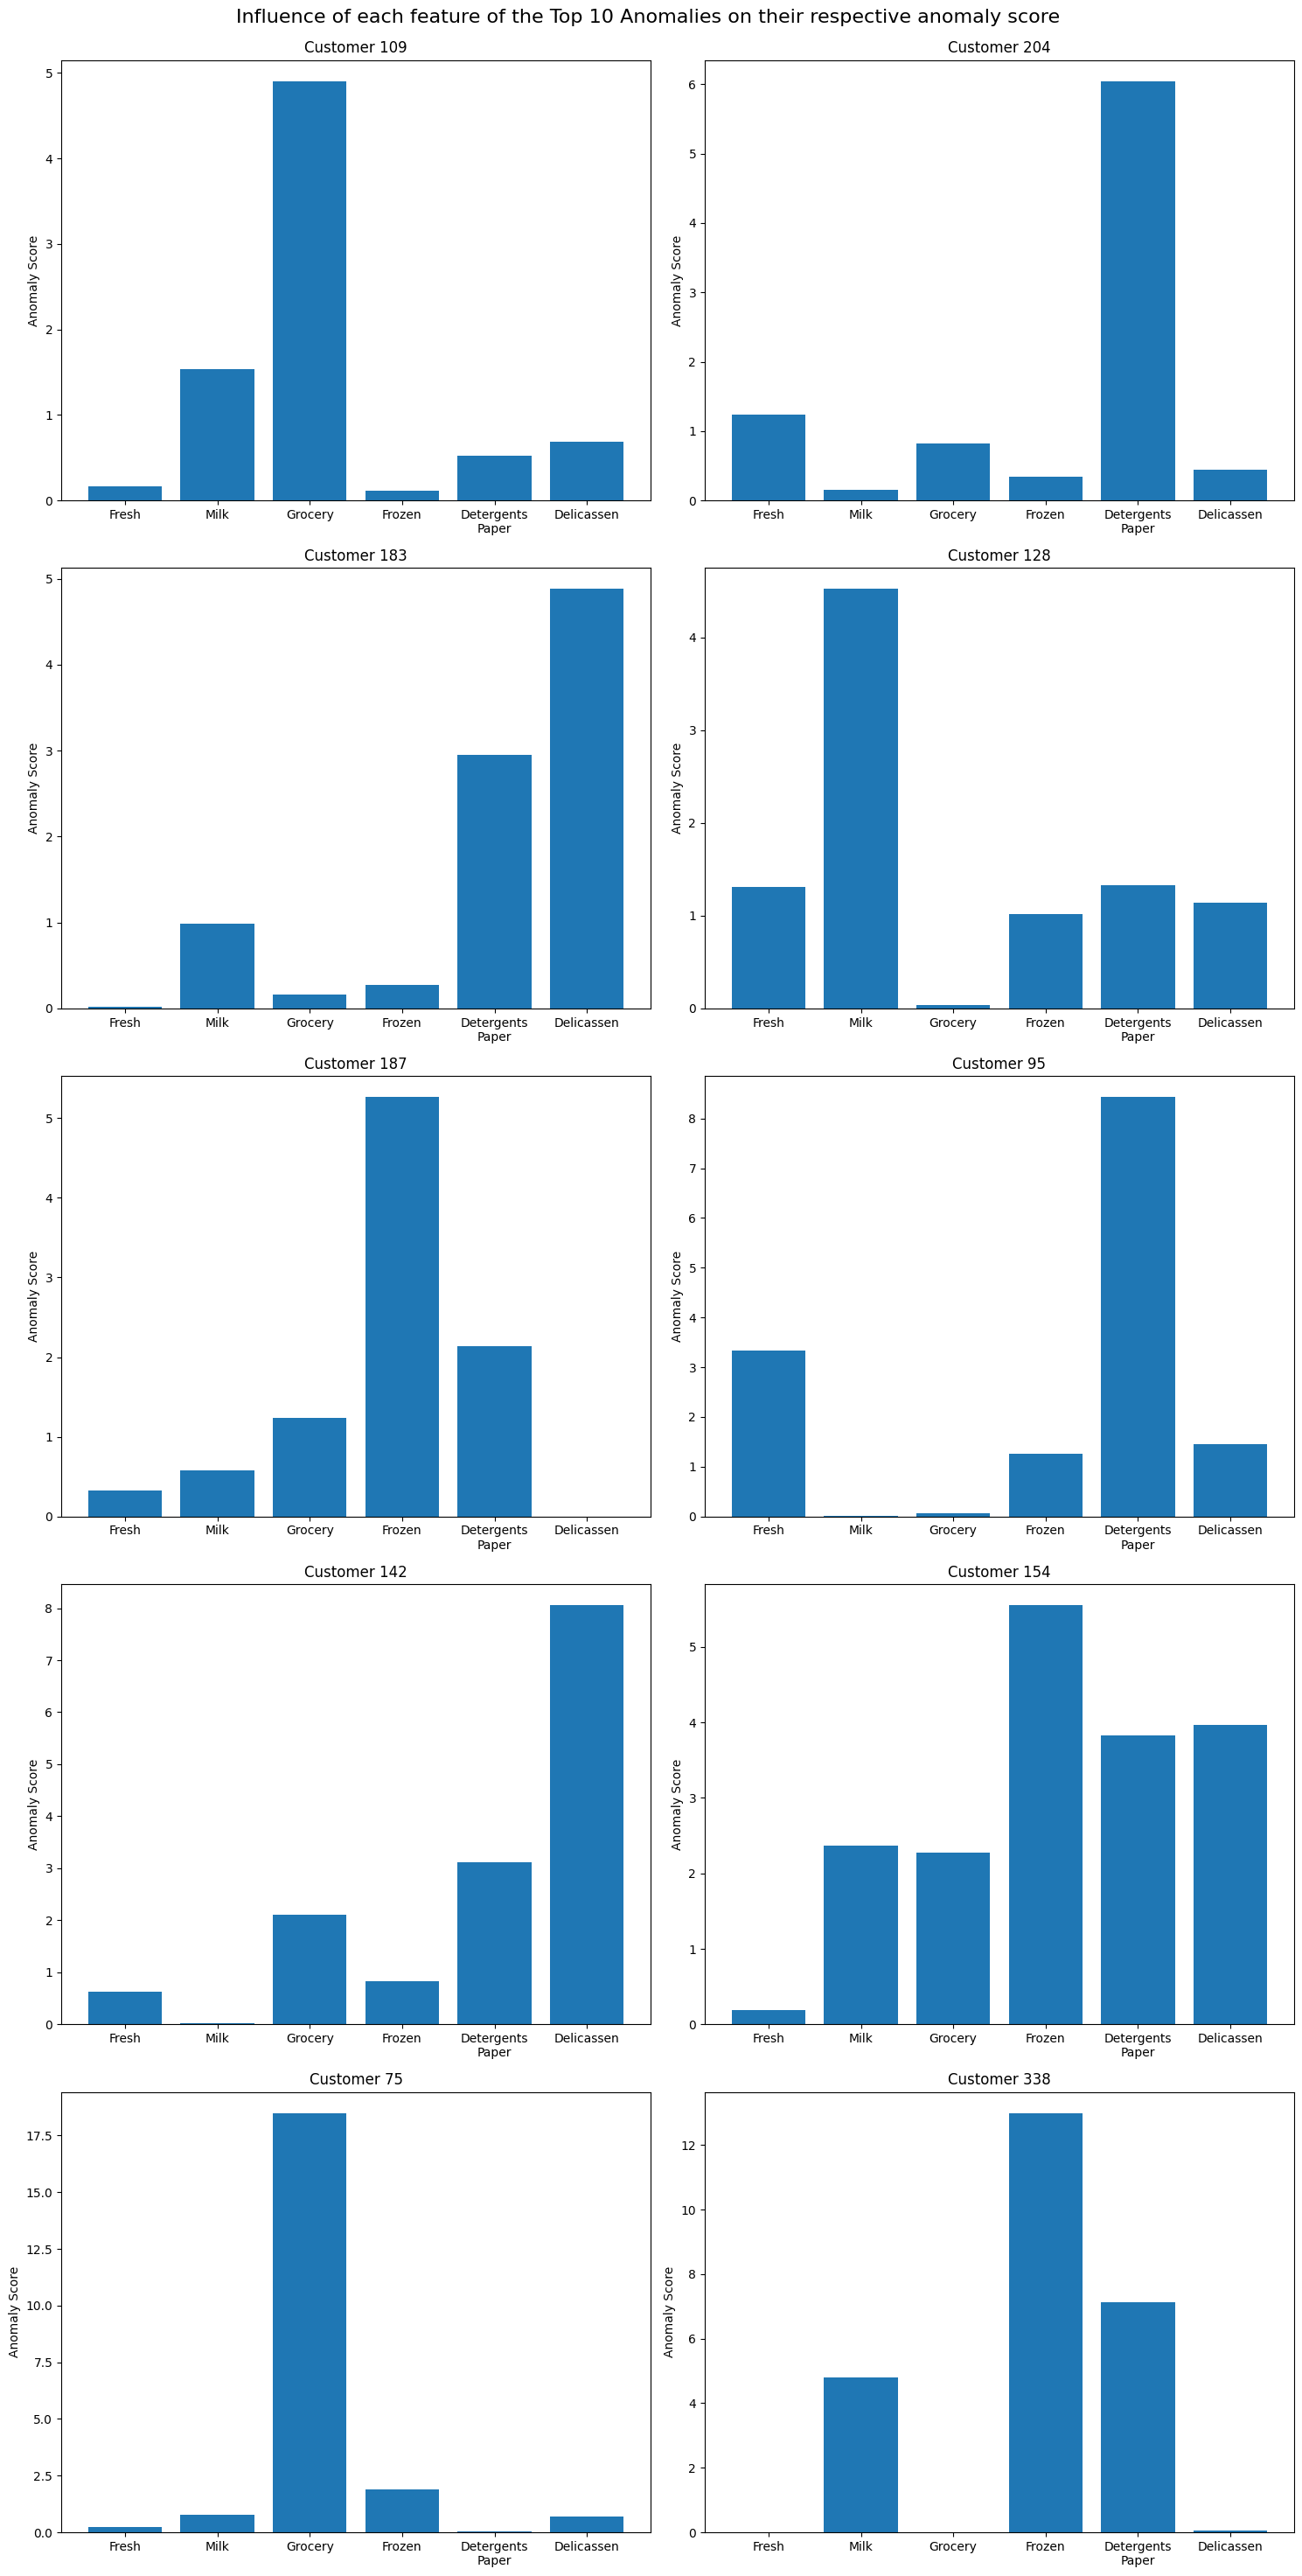

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(15, 30))
for i, anom in enumerate(top_anomalies):
    row = i // 2
    col = i % 2
    axs[row, col].bar(["Fresh", "Milk", "Grocery", "Frozen", "Detergents\nPaper", "Delicassen"], rji[anom])
    axs[row, col].set_ylabel("Anomaly Score")
    axs[row, col].set_title("Customer {}".format(anom))


fig.suptitle("Influence of each feature of the Top 10 Anomalies on their respective anomaly score \n \n", fontsize=16)
plt.tight_layout()
plt.show()

**Visualisation of the Top 10 anomalies inside our data points using t-SNE visualisation**

In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]
import umap

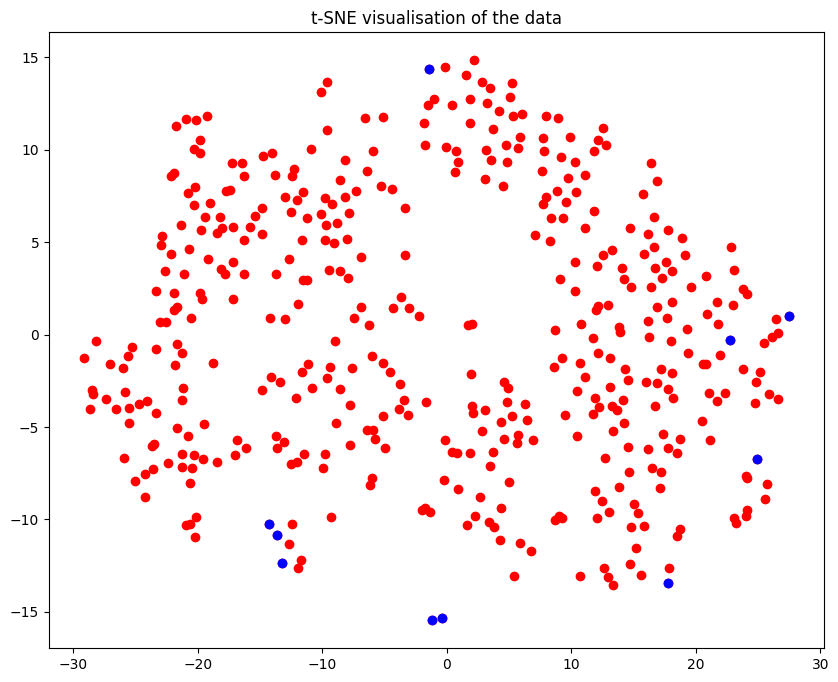

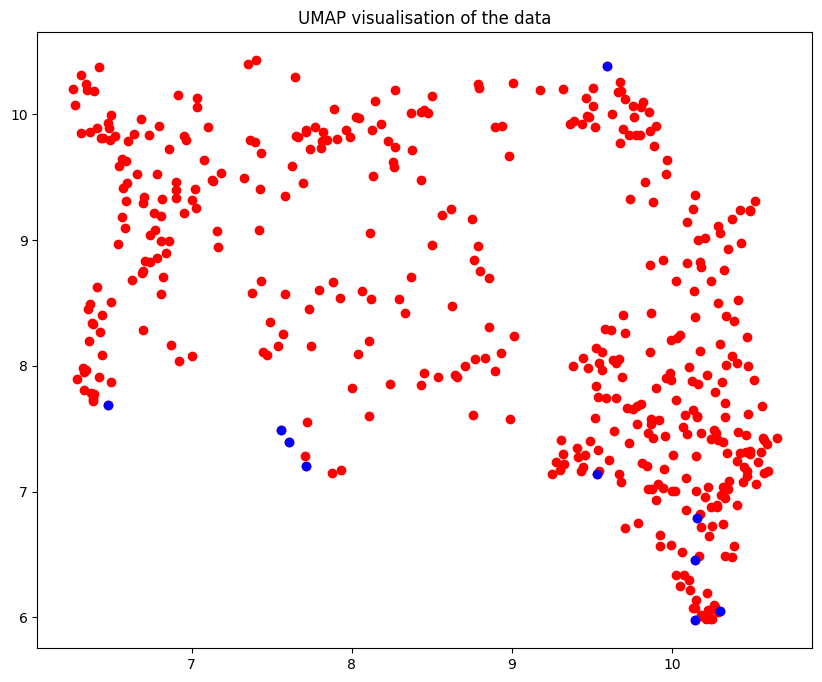

In [ ]:
tsne = TSNE(n_components=2, random_state=50)
X_2d_tsne = tsne.fit_transform(df_log)
top_anomalies = np.argsort(anomaly_scores)[-10:]

plt.figure(figsize=(10, 8))
plt.scatter(X_2d_tsne[:, 0], X_2d_tsne[:, 1], c="r")

# Highlighting the top 10 anomalies.
plt.scatter(X_2d_tsne[top_anomalies, 0], X_2d_tsne[top_anomalies, 1], c="b")

plt.title('t-SNE visualisation of the data')
plt.show()


umap_emb = umap.UMAP(n_components=6)
X_2d_umap = umap_emb.fit_transform(df_log)
top_anomalies = np.argsort(anomaly_scores)[-10:]

plt.figure(figsize=(10, 8))
plt.scatter(X_2d_umap[:, 0], X_2d_umap[:, 1], c="r")

# Highlighting the top 10 anomalies.
plt.scatter(X_2d_umap[top_anomalies, 0], X_2d_umap[top_anomalies, 1], c="b")

plt.title('UMAP visualisation of the data')
plt.show()

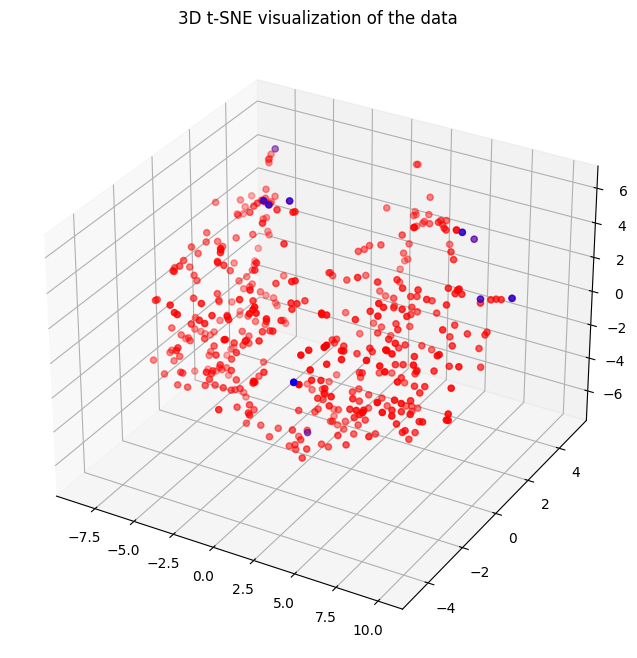

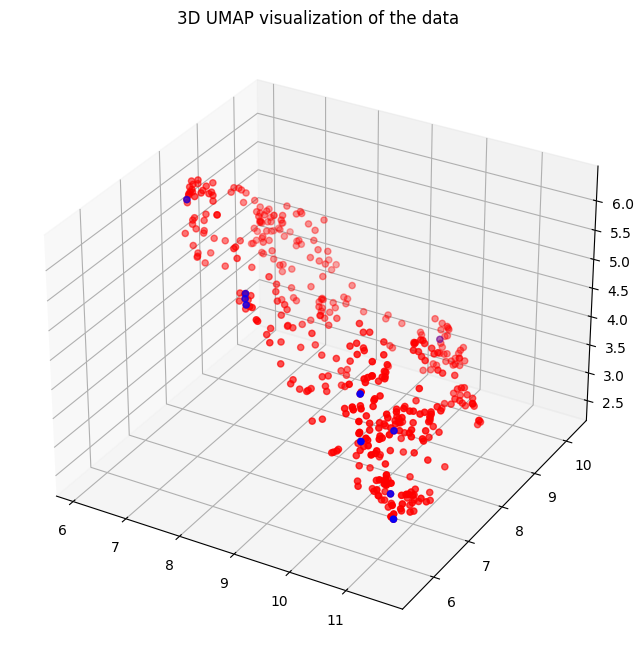

In [ ]:
tsne = TSNE(n_components=3, random_state=0)
X_3d_tsne = tsne.fit_transform(df_log)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = 'r' # Color for normal instances.
ax.scatter(X_3d_tsne[:, 0], X_3d_tsne[:, 1], X_3d_tsne[:, 2], c=colors)

# Highlighting the top 10 anomalies.
colors = 'b' # Color for anomalies.
ax.scatter(X_3d_tsne[top_anomalies, 0], X_3d_tsne[top_anomalies, 1], X_3d_tsne[top_anomalies, 2], c=colors)

plt.title('3D t-SNE visualization of the data')
plt.show()



umap_emb = umap.UMAP(n_components=6)
X_3d_umap = umap_emb.fit_transform(df_log)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_3d_umap[:, 0], X_3d_umap[:, 1], X_3d_umap[:, 2], c="r")

# Highlighting the top 10 anomalies.
ax.scatter(X_3d_umap[top_anomalies, 0], X_3d_umap[top_anomalies, 1], X_3d_umap[top_anomalies, 2], c="b")

plt.title('3D UMAP visualization of the data')
plt.show()

# 4: Cluster Analysis

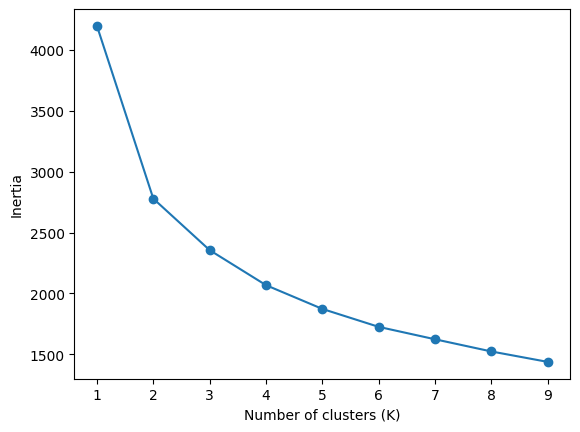

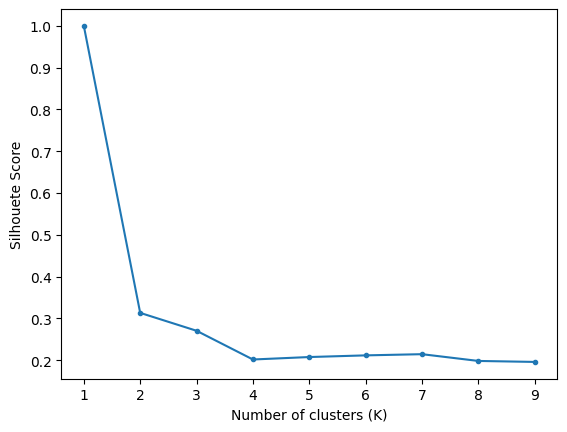

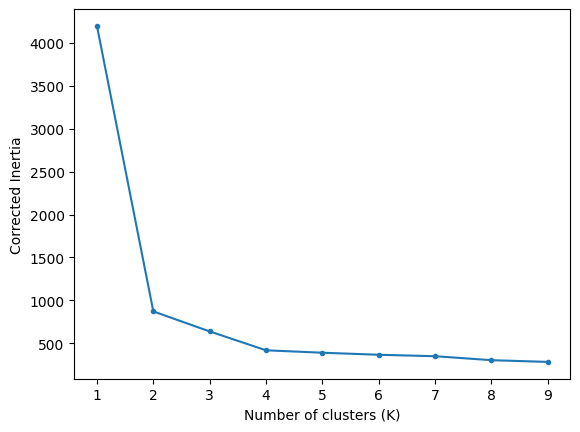

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Convert the CuPy array to a NumPy array for compatibility with pandas
top_anomalies_np = top_anomalies

# Convert the NumPy array to a list
top_anomalies_list = top_anomalies_np.tolist()

# Drop the rows from the dataframe
df_clean = df_log.drop(top_anomalies_list)

# Determine the optimal number of clusters using the elbow method
inertias = []
silhouette_scores = []
K_range = range(1, 10)

for K in K_range:
    kmeans = KMeans(n_clusters=K, max_iter=1000, n_init=1000).fit(df_clean)
    inertias.append(kmeans.inertia_)
    if K>1:
      silhouette_scores.append(silhouette_score(df_clean, kmeans.labels_))
    else:
      silhouette_scores.append(1)


plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.show()

plt.plot(K_range, silhouette_scores, marker='.')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouete Score')
plt.show()

corrected_inertias = [i*j for i,j in zip(inertias, silhouette_scores)]

plt.plot(K_range, corrected_inertias, marker='.')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Corrected Inertia')
plt.show()




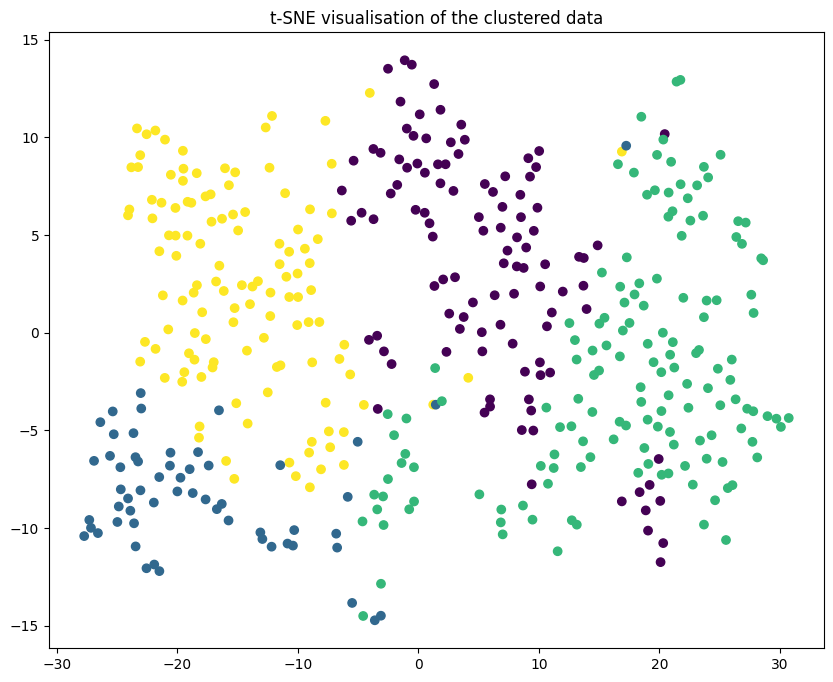

In [ ]:
# Select the optimal number of clusters
K = 4

# Perform k-means clustering
kmeans_tsne = KMeans(n_clusters=K, max_iter=1000, n_init=1000).fit(df_clean)

# Assign clusters to data points
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(df_clean)

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_tsne.fit_predict(df_clean))
plt.title('t-SNE visualisation of the clustered data')
plt.show()

# Compute cluster centroids
centroids_tsne = np.exp(kmeans_tsne.cluster_centers_) - 1

**Using k-means clustering we found a number of 4 clusters optimal using the elbow method. The data was plotted again using t-SNE visualisation and coloring according to the clustering. We used the centroids to plot the annual spending behaviour of the customer groups sorted by the different product categories to gain further insight into the clusters.**

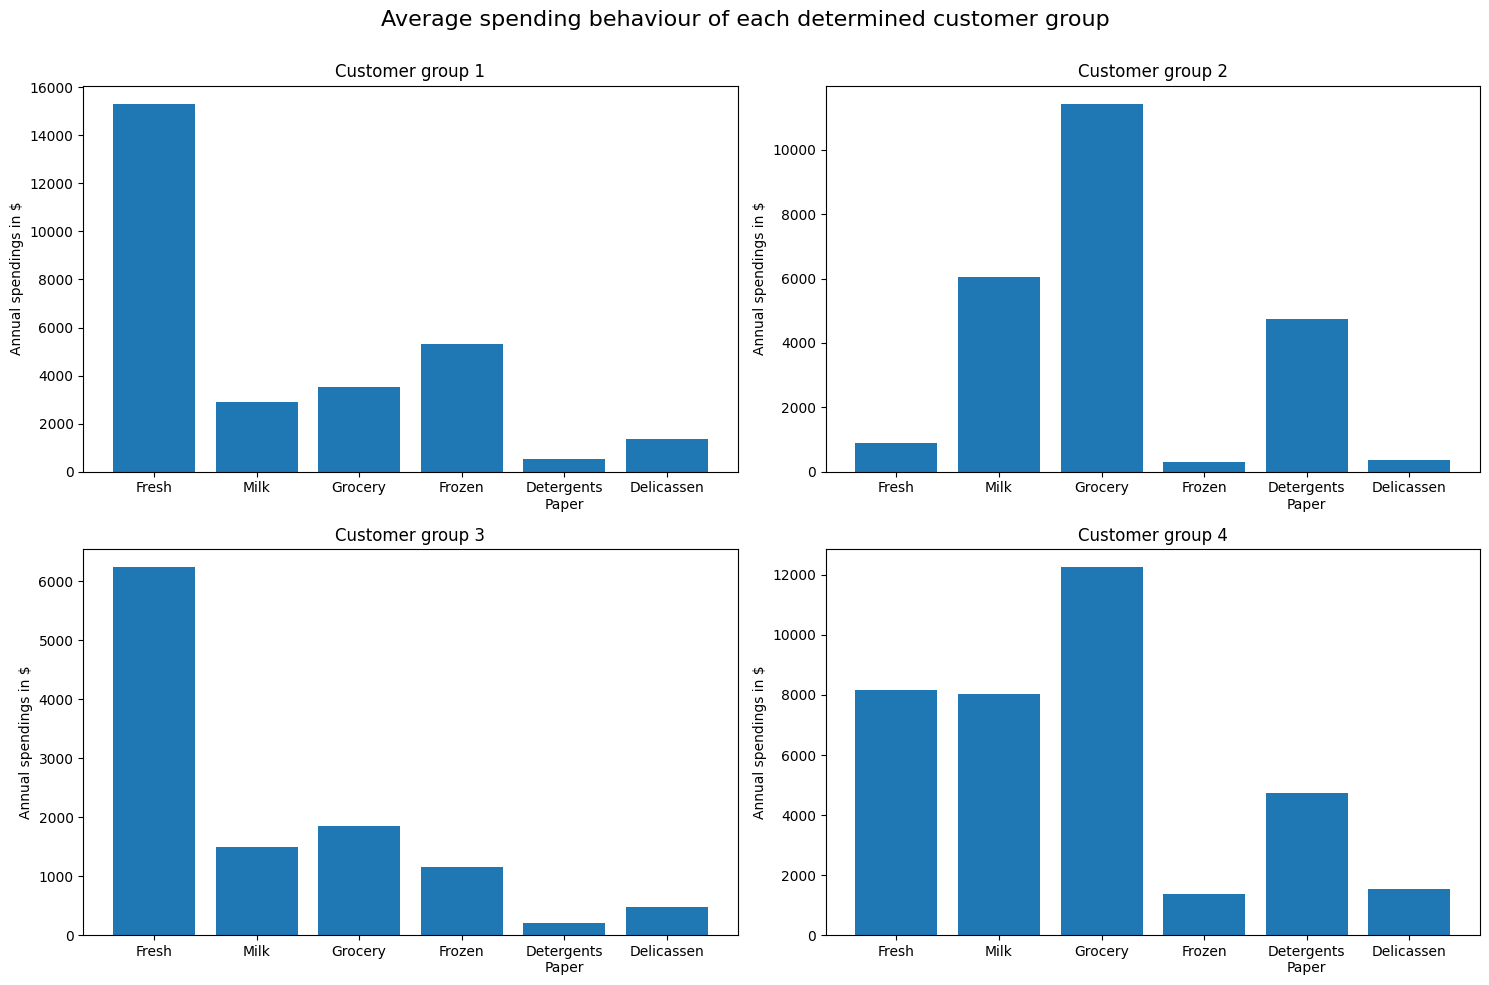

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))


for i in range(len(centroids_tsne)):
    row = i // 2
    col = i % 2

    axs[row, col].bar(["Fresh", "Milk", "Grocery", "Frozen", "Detergents\nPaper", "Delicassen"], centroids_tsne[i])
    axs[row, col].set_ylabel("Annual spendings in $")
    axs[row, col].set_title("Customer group {}".format(i+1))

fig.suptitle("Average spending behaviour of each determined customer group\n", fontsize=16)
plt.tight_layout()
plt.show()